### 1. Configuración de imports y semilla


In [15]:
import os
import random
import numpy as np
import torch

OUT_DIR_02 = Path("./outputs_02_mert_finetune_egfxset")

### 2. Fijación de semilla de reproducibilidad


In [3]:
SEED = 42

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

seed_everything(SEED)

### 3. Selección del dispositivo de cómputo


In [4]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("device:", device, "| torch:", torch.__version__, "| seed:", SEED)

device: mps | torch: 2.9.1 | seed: 42


### 4. Carga del índice del dataset


In [5]:
import pandas as pd
from pathlib import Path

INDEX_CSV_PATH = Path("../egfxset_index.csv")

assert INDEX_CSV_PATH.exists(), f"No existe el índice: {INDEX_CSV_PATH}"

df = pd.read_csv(INDEX_CSV_PATH)

print("Dataset cargado")
print("Número de muestras:", len(df))
print("Columnas:", list(df.columns))
print()
print(df.head())

Dataset cargado
Número de muestras: 8947
Columnas: ['path', 'tone', 'pickup', 'tone_pickup', 'string', 'fret', 'midi_pitch']

                                                path         tone  pickup  \
0  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   
1  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   
2  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   
3  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   
4  /Users/dtenreiro/Documents/TFM/EGFxSet/BluesDr...  BluesDriver  Bridge   

           tone_pickup  string  fret  midi_pitch  
0  BluesDriver__Bridge       1     0          64  
1  BluesDriver__Bridge       1     1          65  
2  BluesDriver__Bridge       1    10          74  
3  BluesDriver__Bridge       1    11          75  
4  BluesDriver__Bridge       1    12          76  


### 5. Split estratificado de train/validación


In [6]:
from sklearn.model_selection import train_test_split

LABEL_COL = "tone_pickup"
assert LABEL_COL in df.columns, f"No existe la columna de etiqueta '{LABEL_COL}'. Columnas: {list(df.columns)}"

train_df, val_df = train_test_split(
    df,
    test_size=0.20,
    random_state=SEED,
    stratify=df[LABEL_COL]
)

print("Split OK")
print("Train:", len(train_df), "| Val:", len(val_df))
print("Clases train:", train_df[LABEL_COL].nunique(), "| Clases val:", val_df[LABEL_COL].nunique())
print("\nDistribución (train):")
print(train_df[LABEL_COL].value_counts().head(10))
print("\nDistribución (val):")
print(val_df[LABEL_COL].value_counts().head(10))

Split OK
Train: 7157 | Val: 1790
Clases train: 65 | Clases val: 65

Distribución (train):
tone_pickup
Chorus__Bridge               111
TapeEcho__Neck               111
BluesDriver__Neck            111
Sweep Echo__Middle-Neck      111
Clean__Middle-Neck           111
Sweep Echo__Bridge           111
Digital Delay__Neck          111
TubeScreamer__Middle         111
Sweep Echo__Bridge-Middle    111
Plate Reverb__Bridge         111
Name: count, dtype: int64

Distribución (val):
tone_pickup
TapeEcho__Middle-Neck        28
Spring Reverb__Neck          28
Sweep Echo__Middle           28
RAT__Middle-Neck             28
TubeScreamer__Middle-Neck    28
Flanger__Neck                28
TapeEcho__Bridge             28
Hall Reverb__Neck            28
RAT__Neck                    28
TubeScreamer__Neck           28
Name: count, dtype: int64


### 6. Codificación de etiquetas


In [7]:
from sklearn.preprocessing import LabelEncoder

LABEL_COL = "tone_pickup"

le = LabelEncoder()
le.fit(df[LABEL_COL])

train_df = train_df.copy()
val_df   = val_df.copy()

train_df["label_id"] = le.transform(train_df[LABEL_COL])
val_df["label_id"]   = le.transform(val_df[LABEL_COL])

num_classes = len(le.classes_)

print("Label encoding OK")
print("Num clases:", num_classes)
print("Ejemplo mapping:")
for i, c in enumerate(le.classes_[:10]):
    print(f"{i} -> {c}")

Label encoding OK
Num clases: 65
Ejemplo mapping:
0 -> BluesDriver__Bridge
1 -> BluesDriver__Bridge-Middle
2 -> BluesDriver__Middle
3 -> BluesDriver__Middle-Neck
4 -> BluesDriver__Neck
5 -> Chorus__Bridge
6 -> Chorus__Bridge-Middle
7 -> Chorus__Middle
8 -> Chorus__Middle-Neck
9 -> Chorus__Neck


### 7. Carga de MERT base y processor


In [8]:
import torch
import torchaudio
import soundfile as sf
import torch.nn.functional as F
from pathlib import Path

from transformers import AutoModel, AutoProcessor


MERT_MODEL_NAME = "m-a-p/MERT-v1-330M"
print("Loading MERT model:", MERT_MODEL_NAME)

mert_model = AutoModel.from_pretrained(
    MERT_MODEL_NAME,
    trust_remote_code=True
).to(device)


processor = AutoProcessor.from_pretrained(
    MERT_MODEL_NAME,
    trust_remote_code=True
)


mert_model.config.output_hidden_states = True


MAX_SECONDS = 5.0
TARGET_SR = 24000

def load_audio(path: str | Path):
    """Carga wav -> mono -> resample a 24k -> recorta a 5s"""
    wav, sr = sf.read(str(path))
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    wav = torch.from_numpy(wav).float()
    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
        sr = TARGET_SR
    wav = wav[: int(sr * MAX_SECONDS)]
    return wav, sr

print("MERT loaded on device:", device)

/opt/anaconda3/envs/mert310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading MERT model: m-a-p/MERT-v1-330M


Some weights of the model checkpoint at m-a-p/MERT-v1-330M were not used when initializing MERTModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing MERTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MERTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MERTModel were not initialized from the model checkpoint at m-a-p/MERT-v1-330M and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MERT loaded on device: mps


### 8. Definición de dataset y dataloaders


In [9]:
import numpy as np
import torch
import torchaudio
import soundfile as sf
from pathlib import Path

MAX_SECONDS = 5.0
TARGET_SR = 24000
TARGET_LEN = int(TARGET_SR * MAX_SECONDS)

def load_audio(path: str | Path):
    wav, sr = sf.read(str(path))


    if isinstance(wav, np.ndarray) and wav.ndim == 2:
        wav = wav.mean(axis=1)


    wav = torch.tensor(wav, dtype=torch.float32)


    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)
        sr = TARGET_SR


    wav = torch.nan_to_num(wav, nan=0.0, posinf=0.0, neginf=0.0)


    if wav.numel() < TARGET_LEN:
        pad = TARGET_LEN - wav.numel()
        wav = torch.cat([wav, torch.zeros(pad, dtype=wav.dtype)], dim=0)
    else:
        wav = wav[:TARGET_LEN]

    return wav, sr

### 9. Definición de hiperparámetros de entrenamiento


In [10]:
BATCH_SIZE = 8
LR = 2e-5
N_LAST_LAYERS = 4
MAX_SECONDS = 5.0

### 10. Definición de collation para audio


In [11]:
def collate_fn(batch):
    wavs, srs, ys = zip(*batch)



    wavs_np = [w.cpu().numpy().astype(np.float32) for w in wavs]

    inputs = processor(
        wavs_np,
        sampling_rate=srs[0],
        return_tensors="pt",
        padding=False,
        return_attention_mask=True
    )

    labels = torch.tensor(ys, dtype=torch.long)
    return inputs, labels

### 11. Construcción final de loaders de entrenamiento


In [12]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

PATH_COL = "path"
LABEL_ID_COL = "label_id"

assert PATH_COL in train_df.columns, f"Falta '{PATH_COL}' en train_df. Columnas: {list(train_df.columns)}"
assert LABEL_ID_COL in train_df.columns, f"Falta '{LABEL_ID_COL}' en train_df. Columnas: {list(train_df.columns)}"

class EGFxSetDataset(Dataset):
    def __init__(self, df):
        self.paths = df[PATH_COL].astype(str).tolist()
        self.labels = df[LABEL_ID_COL].astype(int).tolist()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        wav, sr = load_audio(self.paths[idx])
        y = self.labels[idx]
        return wav, sr, y

train_loader = DataLoader(
    EGFxSetDataset(train_df),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    EGFxSetDataset(val_df),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

inputs, labels = next(iter(train_loader))
print("input_values:", tuple(inputs["input_values"].shape), inputs["input_values"].dtype)
print("attention_mask:", tuple(inputs["attention_mask"].shape), inputs["attention_mask"].dtype)
print("labels:", tuple(labels.shape), labels.dtype)

input_values: (8, 120000) torch.float32
attention_mask: (8, 120000) torch.int32
labels: (8,) torch.int64


### 12. Definición del wrapper fine-tuned


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MERTForTonePickup(nn.Module):
    def __init__(self, mert_model, num_classes: int, proj_dim: int = 256, dropout: float = 0.1):
        super().__init__()
        self.mert = mert_model

        hidden_size = getattr(self.mert.config, "hidden_size", None)
        if hidden_size is None:
            raise ValueError("No se pudo leer hidden_size de mert_model.config.hidden_size")

        self.dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(hidden_size, proj_dim)
        self.classifier = nn.Linear(proj_dim, num_classes)

    def forward(self, inputs, labels=None):
        out = self.mert(**inputs)
        h = out.last_hidden_state


        emb = h.max(dim=1).values
        emb = self.dropout(emb)

        emb = F.relu(self.proj(emb))
        emb = self.dropout(emb)

        logits = self.classifier(emb)
        loss = F.cross_entropy(logits, labels) if labels is not None else None
        return {"loss": loss, "logits": logits, "emb": emb}

ft_model = MERTForTonePickup(mert_model, num_classes=num_classes, proj_dim=256, dropout=0.1).to(device)

print("Wrapper OK: last layer + MAX pooling")

Wrapper OK: last layer + MAX pooling


### 13. Configuración de capas entrenables y optimizador


In [27]:
N_LAST_LAYERS = 4
LR = 2e-5
WEIGHT_DECAY = 0.01


for p in ft_model.parameters():
    p.requires_grad = False


for p in ft_model.proj.parameters():
    p.requires_grad = True
for p in ft_model.classifier.parameters():
    p.requires_grad = True


mert_core = ft_model.mert

layer_stack = None
candidates = [
    ("encoder.layers", lambda m: m.encoder.layers),
    ("model.encoder.layers", lambda m: m.model.encoder.layers),
    ("transformer.layers", lambda m: m.transformer.layers),
    ("model.layers", lambda m: m.model.layers),
    ("layers", lambda m: m.layers),
]

for name, getter in candidates:
    try:
        ls = getter(mert_core)
        if hasattr(ls, "__len__"):
            layer_stack = ls
            stack_name = name
            break
    except Exception:
        pass

assert layer_stack is not None, (
    "No pude encontrar el stack de capas del encoder en este MERT"
)

num_layers = len(layer_stack)
n = min(N_LAST_LAYERS, num_layers)


for layer in layer_stack[num_layers - n:]:
    for p in layer.parameters():
        p.requires_grad = True


optimizer = torch.optim.AdamW(
    [p for p in ft_model.parameters() if p.requires_grad],
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

trainable = sum(p.numel() for p in ft_model.parameters() if p.requires_grad)
total = sum(p.numel() for p in ft_model.parameters())
print(f"Unfroze last {n}/{num_layers} layers via '{stack_name}' + head/proj")
print(f"Trainable params: {trainable:,} / {total:,} ({trainable/total:.2%})")

Unfroze last 4/24 layers via 'encoder.layers' + head/proj
Trainable params: 50,664,001 / 315,708,097 (16.05%)


### 14. Bucle de entrenamiento con early stopping


In [28]:
from tqdm import tqdm
import torch
from pathlib import Path
import math

EPOCHS_MAX = 30
PATIENCE = 3
GRAD_CLIP = 1.0

OUT_DIR_02 = Path("./outputs_02_mert_finetune_egfxset")
OUT_DIR_02.mkdir(parents=True, exist_ok=True)

BEST_CKPT = OUT_DIR_02 / "best.pt"
LAST_CKPT = OUT_DIR_02 / "last.pt"

def run_epoch(loader, train: bool):
    ft_model.train(train)
    total_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(loader, disable=False):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        out = ft_model(inputs, labels=labels)
        loss = out["loss"]

        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(ft_model.parameters(), GRAD_CLIP)
            optimizer.step()

        total_loss += float(loss.item()) * labels.size(0)
        preds = out["logits"].argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total

history_ft = globals().get("history_ft", [])

best_val_loss = math.inf
pat_left = PATIENCE
start_epoch = 1

if LAST_CKPT.exists():
    ckpt_last = torch.load(LAST_CKPT, map_location="cpu")
    if "ft_model_state_dict" in ckpt_last:
        ft_model.load_state_dict(ckpt_last["ft_model_state_dict"], strict=True)
    if "optimizer_state_dict" in ckpt_last:
        try:
            optimizer.load_state_dict(ckpt_last["optimizer_state_dict"])
            print(f"Resumed optimizer state from {LAST_CKPT}")
        except Exception as e:
            print(f"WARNING: could not load optimizer state: {e}")
    if "history_ft" in ckpt_last:
        history_ft = ckpt_last["history_ft"]
    if "epoch" in ckpt_last:
        start_epoch = int(ckpt_last["epoch"]) + 1
    if "best_val_loss" in ckpt_last:
        best_val_loss = float(ckpt_last["best_val_loss"])
    if "pat_left" in ckpt_last:
        pat_left = int(ckpt_last["pat_left"])

    print(f"Resumed model from {LAST_CKPT} | next epoch: {start_epoch} | best_val_loss: {best_val_loss:.4f} | pat_left: {pat_left}")
else:

    if BEST_CKPT.exists():
        ckpt_best = torch.load(BEST_CKPT, map_location="cpu")
        if "best_val_loss" in ckpt_best:
            best_val_loss = float(ckpt_best["best_val_loss"])
        print(f"Loaded best_val_loss={best_val_loss:.4f} from {BEST_CKPT}")


for epoch in range(start_epoch, EPOCHS_MAX + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader, train=False)
    history_ft.append((epoch, tr_loss, tr_acc, va_loss, va_acc))

    print(f"epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")


    torch.save(
        {
            "ft_model_state_dict": ft_model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch,
            "history_ft": history_ft,
            "best_val_loss": best_val_loss,
            "pat_left": pat_left,
        },
        LAST_CKPT
    )


    if va_loss < best_val_loss - 1e-4:
        best_val_loss = va_loss
        pat_left = PATIENCE
        torch.save(
            {
                "ft_model_state_dict": ft_model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "best_val_loss": best_val_loss,
                "history_ft": history_ft,
                "pat_left": pat_left,
                "label_classes": le.classes_.tolist(),
                "n_last_layers": int(N_LAST_LAYERS),
                "mert_model_name": MERT_MODEL_NAME,
                "proj_dim": 256,
                "pooling": "max_last_hidden_state",
            },
            BEST_CKPT
        )
        print(f"new best val_loss={best_val_loss:.4f} -> saved {BEST_CKPT}")
    else:
        pat_left -= 1
        print(f"no improvement | patience left {pat_left}/{PATIENCE}")
        if pat_left == 0:
            print("Early stopping")
            break

print("Training done.")
print("best_val_loss:", best_val_loss)
print("Best ckpt:", BEST_CKPT)
print("Last ckpt:", LAST_CKPT)

100%|█████████████████████████████████████████| 224/224 [01:48<00:00,  2.07it/s]


epoch 01 | train loss 4.0357 acc 0.038 | val loss 3.7734 acc 0.081
new best val_loss=3.7734 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:51<00:00,  2.02it/s]


epoch 02 | train loss 3.3683 acc 0.137 | val loss 2.9204 acc 0.265
new best val_loss=2.9204 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:46<00:00,  2.11it/s]


epoch 03 | train loss 2.5124 acc 0.316 | val loss 2.2208 acc 0.439
new best val_loss=2.2208 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:40<00:00,  2.22it/s]


epoch 04 | train loss 1.8480 acc 0.487 | val loss 1.6856 acc 0.567
new best val_loss=1.6856 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:48<00:00,  2.06it/s]


epoch 05 | train loss 1.3231 acc 0.632 | val loss 1.2643 acc 0.674
new best val_loss=1.2643 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:41<00:00,  2.22it/s]


epoch 06 | train loss 0.9339 acc 0.752 | val loss 0.9227 acc 0.766
new best val_loss=0.9227 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:41<00:00,  2.22it/s]


epoch 07 | train loss 0.6425 acc 0.831 | val loss 0.7410 acc 0.794
new best val_loss=0.7410 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:36<00:00,  2.32it/s]


epoch 08 | train loss 0.4442 acc 0.877 | val loss 0.5804 acc 0.826
new best val_loss=0.5804 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:42<00:00,  2.19it/s]


epoch 09 | train loss 0.3138 acc 0.912 | val loss 0.5072 acc 0.830
new best val_loss=0.5072 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:36<00:00,  2.33it/s]


epoch 10 | train loss 0.2274 acc 0.934 | val loss 0.4623 acc 0.846
new best val_loss=0.4623 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:35<00:00,  2.34it/s]


epoch 11 | train loss 0.1663 acc 0.950 | val loss 0.4301 acc 0.855
new best val_loss=0.4301 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:35<00:00,  2.34it/s]


epoch 12 | train loss 0.1182 acc 0.965 | val loss 0.3870 acc 0.882
new best val_loss=0.3870 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:41<00:00,  2.20it/s]


epoch 13 | train loss 0.0770 acc 0.979 | val loss 0.4095 acc 0.874
no improvement | patience left 2/3


100%|█████████████████████████████████████████| 224/224 [01:32<00:00,  2.42it/s]


epoch 14 | train loss 0.0482 acc 0.986 | val loss 0.3417 acc 0.901
new best val_loss=0.3417 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:39<00:00,  2.26it/s]


epoch 15 | train loss 0.0405 acc 0.988 | val loss 0.3648 acc 0.895
no improvement | patience left 2/3


100%|█████████████████████████████████████████| 224/224 [01:40<00:00,  2.23it/s]


epoch 16 | train loss 0.0290 acc 0.992 | val loss 0.2920 acc 0.916
new best val_loss=0.2920 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:37<00:00,  2.30it/s]


epoch 17 | train loss 0.0272 acc 0.991 | val loss 0.2776 acc 0.923
new best val_loss=0.2776 -> saved outputs_02_mert_finetune_egfxset/best.pt


100%|█████████████████████████████████████████| 224/224 [01:37<00:00,  2.30it/s]


epoch 18 | train loss 0.0271 acc 0.992 | val loss 0.3822 acc 0.903
no improvement | patience left 2/3


100%|█████████████████████████████████████████| 224/224 [01:35<00:00,  2.35it/s]


epoch 19 | train loss 0.0208 acc 0.994 | val loss 0.5762 acc 0.864
no improvement | patience left 1/3


100%|█████████████████████████████████████████| 224/224 [01:35<00:00,  2.35it/s]


epoch 20 | train loss 0.0198 acc 0.995 | val loss 0.3704 acc 0.908
no improvement | patience left 0/3
Early stopping
Training done.
best_val_loss: 0.27758973892830185
Best ckpt: outputs_02_mert_finetune_egfxset/best.pt
Last ckpt: outputs_02_mert_finetune_egfxset/last.pt


### 15. Guardado de checkpoint y metadatos


In [29]:
import json
import numpy as np
import torch
from pathlib import Path

OUT_DIR_02 = Path("./outputs_02_mert_finetune_egfxset")
OUT_DIR_02.mkdir(parents=True, exist_ok=True)

ckpt_path = OUT_DIR_02 / "mert_ft_last4layers_headproj.pt"
meta_path = OUT_DIR_02 / "metadata.json"


torch.save(
    {
        "ft_model_state_dict": ft_model.state_dict(),
        "label_classes": le.classes_.tolist(),
        "label_col": LABEL_COL,
        "path_col": PATH_COL,
        "num_classes": int(num_classes),
        "seed": int(SEED),
        "n_last_layers": int(N_LAST_LAYERS),
    },
    ckpt_path
)


meta = {
    "mert_model_name": MERT_MODEL_NAME,
    "target_sr": TARGET_SR,
    "max_seconds": MAX_SECONDS,
    "batch_size": BATCH_SIZE,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "n_last_layers": N_LAST_LAYERS,
}
if "history_ft" in globals():
    meta["history_ft"] = [
        {"epoch": int(e), "train_loss": float(tl), "train_acc": float(ta), "val_loss": float(vl), "val_acc": float(va)}
        for (e, tl, ta, vl, va) in history_ft
    ]

meta_path.write_text(json.dumps(meta, indent=2), encoding="utf-8")

print("Saved:")
print(" -", ckpt_path)
print(" -", meta_path)

Saved:
 - outputs_02_mert_finetune_egfxset/mert_ft_last4layers_headproj.pt
 - outputs_02_mert_finetune_egfxset/metadata.json


### 16. Dataset auxiliar para extracción de embeddings


In [24]:
from torch.utils.data import Dataset, DataLoader

class FullDFDataset(Dataset):
    def __init__(self, df):
        self.paths = df[PATH_COL].astype(str).tolist()
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        wav, sr = load_audio(self.paths[idx])
        return wav, sr

def collate_audio_only(batch):
    wavs, srs = zip(*batch)


    wavs_np = [w.cpu().numpy().astype(np.float32) for w in wavs]

    inputs = processor(
        wavs_np,
        sampling_rate=srs[0],
        return_tensors="pt",
        padding=False,
        return_attention_mask=True
    )
    return inputs

### 17. Extracción de embeddings de train y validación


In [26]:
from tqdm import tqdm

FT_TRAIN_EMBS_PATH  = OUT_DIR_02 / "mert_ft_embs_train.npy"
FT_VAL_EMBS_PATH    = OUT_DIR_02 / "mert_ft_embs_val.npy"
FT_TRAIN_INDEX_PATH = OUT_DIR_02 / "egfxset_index_used_train.csv"
FT_VAL_INDEX_PATH   = OUT_DIR_02 / "egfxset_index_used_val.csv"


train_df.to_csv(FT_TRAIN_INDEX_PATH, index=False)
val_df.to_csv(FT_VAL_INDEX_PATH, index=False)

def extract_embeddings_df(df_subset, out_embs_path, batch_size=8):
    loader = DataLoader(
        FullDFDataset(df_subset),
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_audio_only
    )

    all_embs = []
    ft_model.eval()

    with torch.no_grad():
        for inputs in tqdm(loader):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            out = ft_model(inputs, labels=None)
            emb = out["emb"].detach().cpu().numpy()
            all_embs.append(emb)

    all_embs = np.vstack(all_embs)
    np.save(out_embs_path, all_embs)
    print("Saved:", out_embs_path, "| shape:", all_embs.shape)
    return all_embs

BATCH_SIZE = 8
embs_train = extract_embeddings_df(train_df, FT_TRAIN_EMBS_PATH, batch_size=BATCH_SIZE)
embs_val   = extract_embeddings_df(val_df,   FT_VAL_EMBS_PATH,   batch_size=BATCH_SIZE)

print("Index snapshots saved:")
print(" -", FT_TRAIN_INDEX_PATH)
print(" -", FT_VAL_INDEX_PATH)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 895/895 [06:28<00:00,  2.31it/s]


Saved: outputs_02_mert_finetune_egfxset/mert_ft_embs_train.npy | shape: (7157, 256)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [01:58<00:00,  1.89it/s]

Saved: outputs_02_mert_finetune_egfxset/mert_ft_embs_val.npy | shape: (1790, 256)
Index snapshots saved:
 - outputs_02_mert_finetune_egfxset/egfxset_index_used_train.csv
 - outputs_02_mert_finetune_egfxset/egfxset_index_used_val.csv


### 18. Verificación de rutas y artefactos de embeddings


In [27]:
import numpy as np
import pandas as pd
from pathlib import Path

OUT_DIR_02 = Path("./outputs_02_mert_finetune_egfxset")

FT_TRAIN_EMBS_PATH  = OUT_DIR_02 / "mert_ft_embs_train.npy"
FT_VAL_EMBS_PATH    = OUT_DIR_02 / "mert_ft_embs_val.npy"
FT_TRAIN_INDEX_PATH = OUT_DIR_02 / "egfxset_index_used_train.csv"
FT_VAL_INDEX_PATH   = OUT_DIR_02 / "egfxset_index_used_val.csv"

assert FT_TRAIN_EMBS_PATH.exists()
assert FT_VAL_EMBS_PATH.exists()
assert FT_TRAIN_INDEX_PATH.exists()
assert FT_VAL_INDEX_PATH.exists()

print("OK paths")

OK paths


### 19. Carga de embeddings y etiquetas de train/validación


In [28]:
LABEL_COL = "tone_pickup"

train_df = pd.read_csv(FT_TRAIN_INDEX_PATH)
val_df   = pd.read_csv(FT_VAL_INDEX_PATH)

X_train = np.load(FT_TRAIN_EMBS_PATH)
X_val   = np.load(FT_VAL_EMBS_PATH)

assert len(train_df) == X_train.shape[0], (len(train_df), X_train.shape)
assert len(val_df)   == X_val.shape[0],   (len(val_df), X_val.shape)


classes = sorted(pd.concat([train_df[LABEL_COL], val_df[LABEL_COL]]).unique().tolist())
class2id = {c:i for i,c in enumerate(classes)}

y_train = train_df[LABEL_COL].map(class2id).to_numpy()
y_val   = val_df[LABEL_COL].map(class2id).to_numpy()

num_classes = len(classes)
chance = 1.0 / num_classes

print("X_train:", X_train.shape, "| X_val:", X_val.shape)
print("num_classes:", num_classes, "| chance:", chance)

X_train: (7157, 256) | X_val: (1790, 256)
num_classes: 65 | chance: 0.015384615384615385


### 20. Funciones de normalización y métricas Top-k


In [29]:
def l2_normalize(X, eps=1e-12):
    denom = np.linalg.norm(X, axis=1, keepdims=True)
    denom = np.maximum(denom, eps)
    return X / denom

def topk_retrieval_metrics(X_queries, y_queries, X_gallery, y_gallery, k_list=(1,5), exclude_self=False):
    """
    Cosine similarity = dot product after L2 normalization.
    exclude_self=True solo tiene sentido cuando queries==gallery (leave-one-out).
    """
    Xq = l2_normalize(X_queries.astype(np.float32))
    Xg = l2_normalize(X_gallery.astype(np.float32))


    S = Xq @ Xg.T

    if exclude_self:

        assert S.shape[0] == S.shape[1], "exclude_self requiere queries==gallery"
        np.fill_diagonal(S, -np.inf)



    maxK = max(k_list)
    top_idx = np.argpartition(-S, kth=maxK-1, axis=1)[:, :maxK]

    row = np.arange(S.shape[0])[:, None]
    top_idx = top_idx[row, np.argsort(-S[row, top_idx], axis=1)]


    retrieved = y_gallery[top_idx]

    metrics = {}
    for k in k_list:
        hit = (retrieved[:, :k] == y_queries[:, None]).any(axis=1)
        metrics[f"top_{k}"] = float(hit.mean())


    y_pred_top1 = retrieved[:, 0].copy()

    return metrics, y_pred_top1

### 21. Cálculo de métricas retrieval correctas (train/val)


In [30]:
results = []

m_train, pred_train = topk_retrieval_metrics(
    X_train, y_train, X_train, y_train,
    k_list=(1,5), exclude_self=True
)
results.append(("MERT fine-tuned", "Train→Train (LOO)", X_train.shape[1], m_train["top_1"], m_train["top_5"]))

m_val, pred_val = topk_retrieval_metrics(
    X_val, y_val, X_val, y_val,
    k_list=(1,5), exclude_self=True
)
results.append(("MERT fine-tuned", "Val→Val (LOO)", X_val.shape[1], m_val["top_1"], m_val["top_5"]))


m_v2t, pred_v2t = topk_retrieval_metrics(
    X_val, y_val, X_train, y_train,
    k_list=(1,5), exclude_self=False
)
results.append(("MERT fine-tuned", "Val→Train (retrieval)", X_train.shape[1], m_v2t["top_1"], m_v2t["top_5"]))

res_df = pd.DataFrame(results, columns=["Modelo","Configuración","Dimensión","Top-1","Top-5"])
res_df["Chance (1/C)"] = chance
res_df["Top-1 vs chance"] = res_df["Top-1"] / chance

display(res_df)

,Modelo,Configuración,Dimensión,Top-1,Top-5,Chance (1/C),Top-1 vs chance
0,MERT fine-tuned,Train→Train (LOO),256,0.997625,0.998882,0.015385,64.845606
1,MERT fine-tuned,Val→Val (LOO),256,0.954190,0.980447,0.015385,62.022346
2,MERT fine-tuned,Val→Train (retrieval),256,0.960894,0.972067,0.015385,62.458101


### 22. Exportación de tabla de resultados


In [31]:
OUT_TABLE = OUT_DIR_02 / "results_retrieval_mert_ft_train_val.csv"
res_df.to_csv(OUT_TABLE, index=False)
print("Saved:", OUT_TABLE)

Saved: outputs_02_mert_finetune_egfxset/results_retrieval_mert_ft_train_val.csv


### 23. Matriz de confusión Top-1 para train y validación


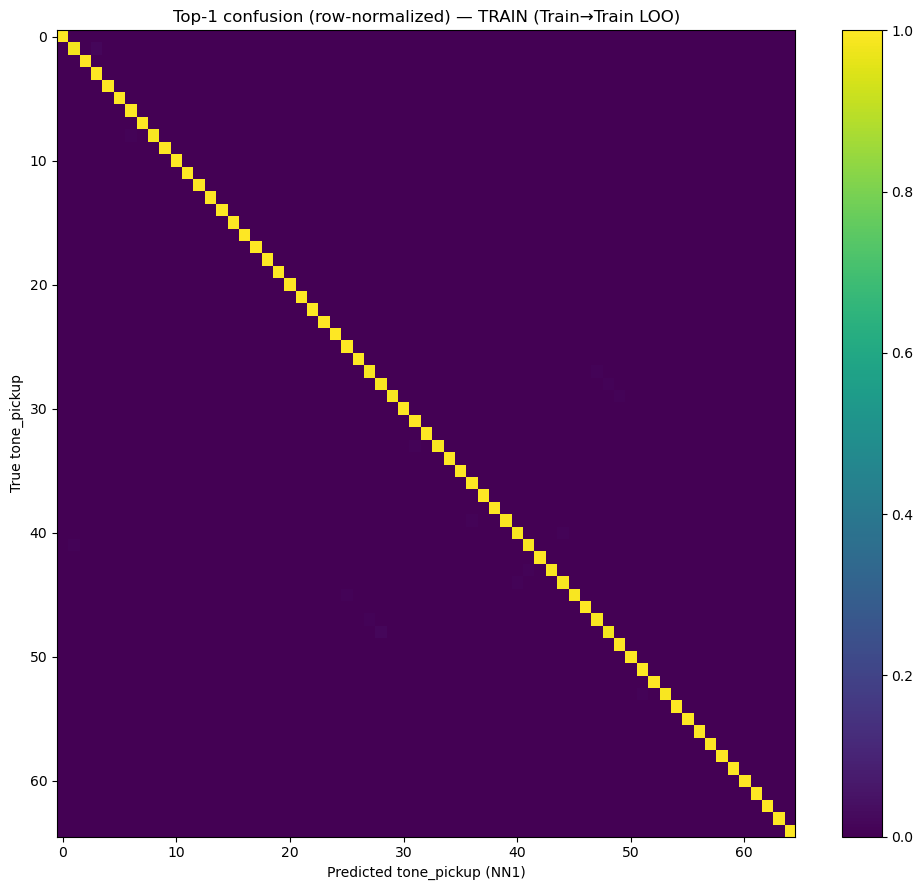

row_0                       col_0                      
Spring Reverb__Middle-Neck  Hall Reverb__Middle-Neck       2
BluesDriver__Bridge-Middle  BluesDriver__Middle-Neck       2
RAT__Bridge                 RAT__Neck                      1
Plate Reverb__Neck          Plate Reverb__Bridge-Middle    1
Sweep Echo__Middle-Neck     Sweep Echo__Bridge-Middle      1
Phaser__Middle-Neck         Phaser__Bridge-Middle          1
Spring Reverb__Middle       Hall Reverb__Middle            1
Spring Reverb__Bridge       Hall Reverb__Bridge            1
Hall Reverb__Neck           Spring Reverb__Neck            1
Hall Reverb__Middle         Spring Reverb__Middle          1
RAT__Bridge-Middle          BluesDriver__Bridge-Middle     1
Hall Reverb__Middle-Neck    Spring Reverb__Middle-Neck     1
RAT__Middle-Neck            RAT__Bridge-Middle             1
RAT__Neck                   RAT__Bridge                    1
Chorus__Middle-Neck         Chorus__Bridge-Middle          1
RAT__Middle                 T

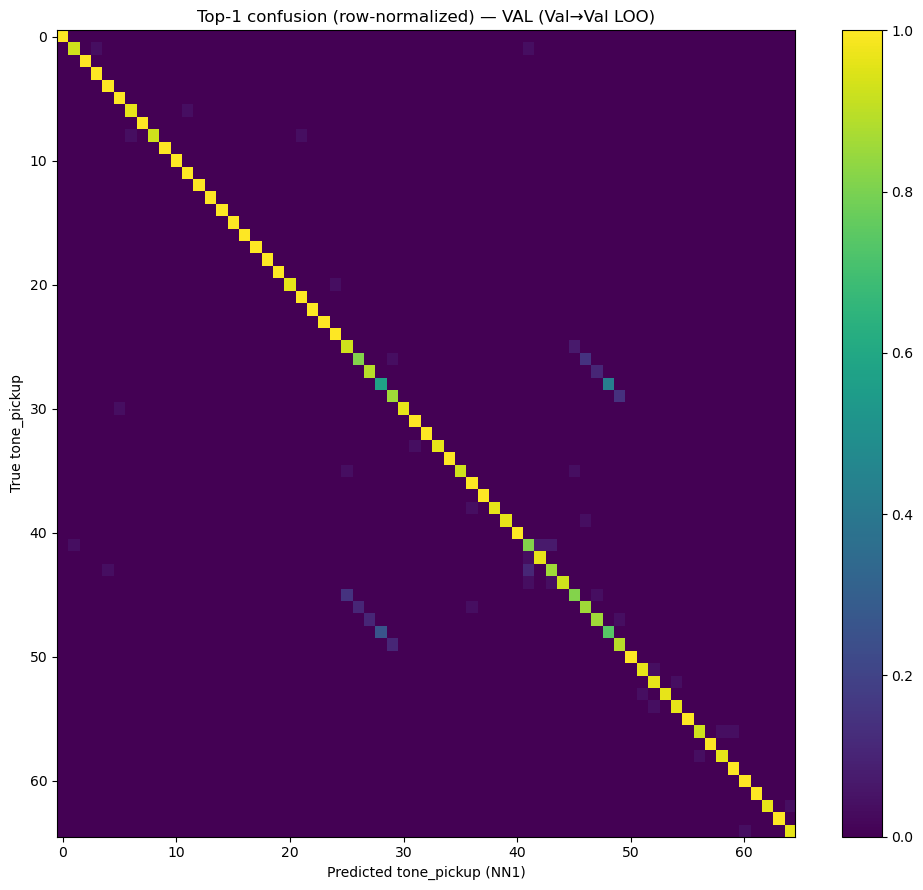

row_0                         col_0                       
Hall Reverb__Middle-Neck      Spring Reverb__Middle-Neck      12
Spring Reverb__Middle-Neck    Hall Reverb__Middle-Neck         7
Hall Reverb__Bridge-Middle    Spring Reverb__Bridge-Middle     4
Hall Reverb__Neck             Spring Reverb__Neck              4
Spring Reverb__Bridge         Hall Reverb__Bridge              4
Spring Reverb__Middle         Hall Reverb__Middle              3
RAT__Middle-Neck              RAT__Bridge-Middle               3
Spring Reverb__Bridge-Middle  Hall Reverb__Bridge-Middle       3
Hall Reverb__Middle           Spring Reverb__Middle            3
Spring Reverb__Neck           Hall Reverb__Neck                3
Hall Reverb__Bridge           Spring Reverb__Bridge            2
RAT__Bridge-Middle            RAT__Middle-Neck                 2
                              RAT__Middle                      2
Plate Reverb__Bridge          Hall Reverb__Bridge              1
TapeEcho__Middle-Neck         T

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def top1_confusion_like_original(X, labels_str, title):
    """
    Replica tu notebook:
    - L2 normalize
    - cosine sim matrix
    - fill diagonal -inf
    - nn1
    - pd.crosstab
    - row-normalize
    - imshow
    """
    X = X.astype(np.float32)
    X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)

    S = X @ X.T
    np.fill_diagonal(S, -np.inf)
    nn1 = np.argmax(S, axis=1)

    y_true = labels_str.astype(str)
    y_pred = labels_str[nn1].astype(str)

    cm = pd.crosstab(y_true, y_pred)
    cm = cm.reindex(index=sorted(cm.index), columns=sorted(cm.columns), fill_value=0)
    cm_norm = cm.div(cm.sum(axis=1).replace(0, 1), axis=0)

    plt.figure(figsize=(10, 9))
    plt.imshow(cm_norm.to_numpy(), aspect="auto")
    plt.title(title)
    plt.xlabel("Predicted tone_pickup (NN1)")
    plt.ylabel("True tone_pickup")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


    cm_off = cm.copy()
    for k in cm_off.index:
        if k in cm_off.columns:
            cm_off.loc[k, k] = 0
    top_conf = cm_off.stack().sort_values(ascending=False).head(20)
    return cm, cm_norm, top_conf



labels_train = train_df["tone_pickup"].astype(str).to_numpy()
cm_tr, cmn_tr, topconf_tr = top1_confusion_like_original(
    X_train, labels_train,
    title="Top-1 confusion (row-normalized) — TRAIN (Train→Train LOO)"
)
display(topconf_tr)


labels_val = val_df["tone_pickup"].astype(str).to_numpy()
cm_va, cmn_va, topconf_va = top1_confusion_like_original(
    X_val, labels_val,
    title="Top-1 confusion (row-normalized) — VAL (Val→Val LOO)"
)
display(topconf_va)

### 24. Visualización t-SNE sobre train y validación


t-SNE perplexity (TRAIN): 30
Saved: outputs_02_mert_finetune_egfxset/figures_mert_ft/mert_ft_tsne_global_train_tone_pickup.png


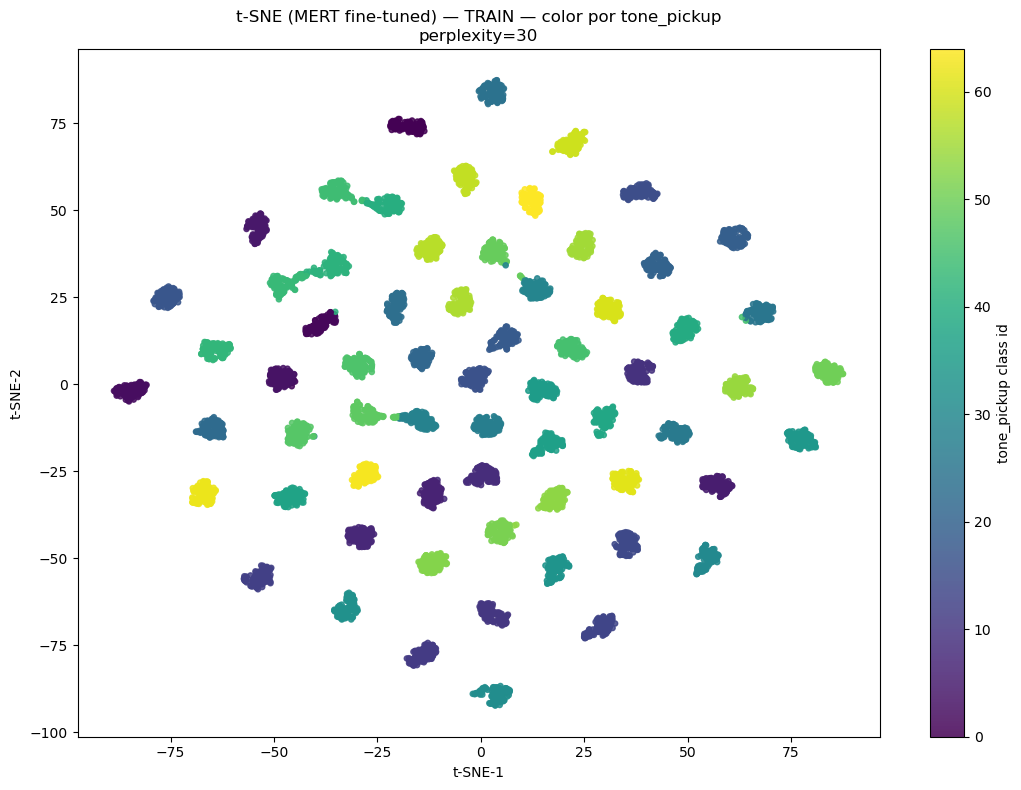

Saved: outputs_02_mert_finetune_egfxset/figures_mert_ft/mert_ft_tsne_subplots_train_tone_color_pickup.png


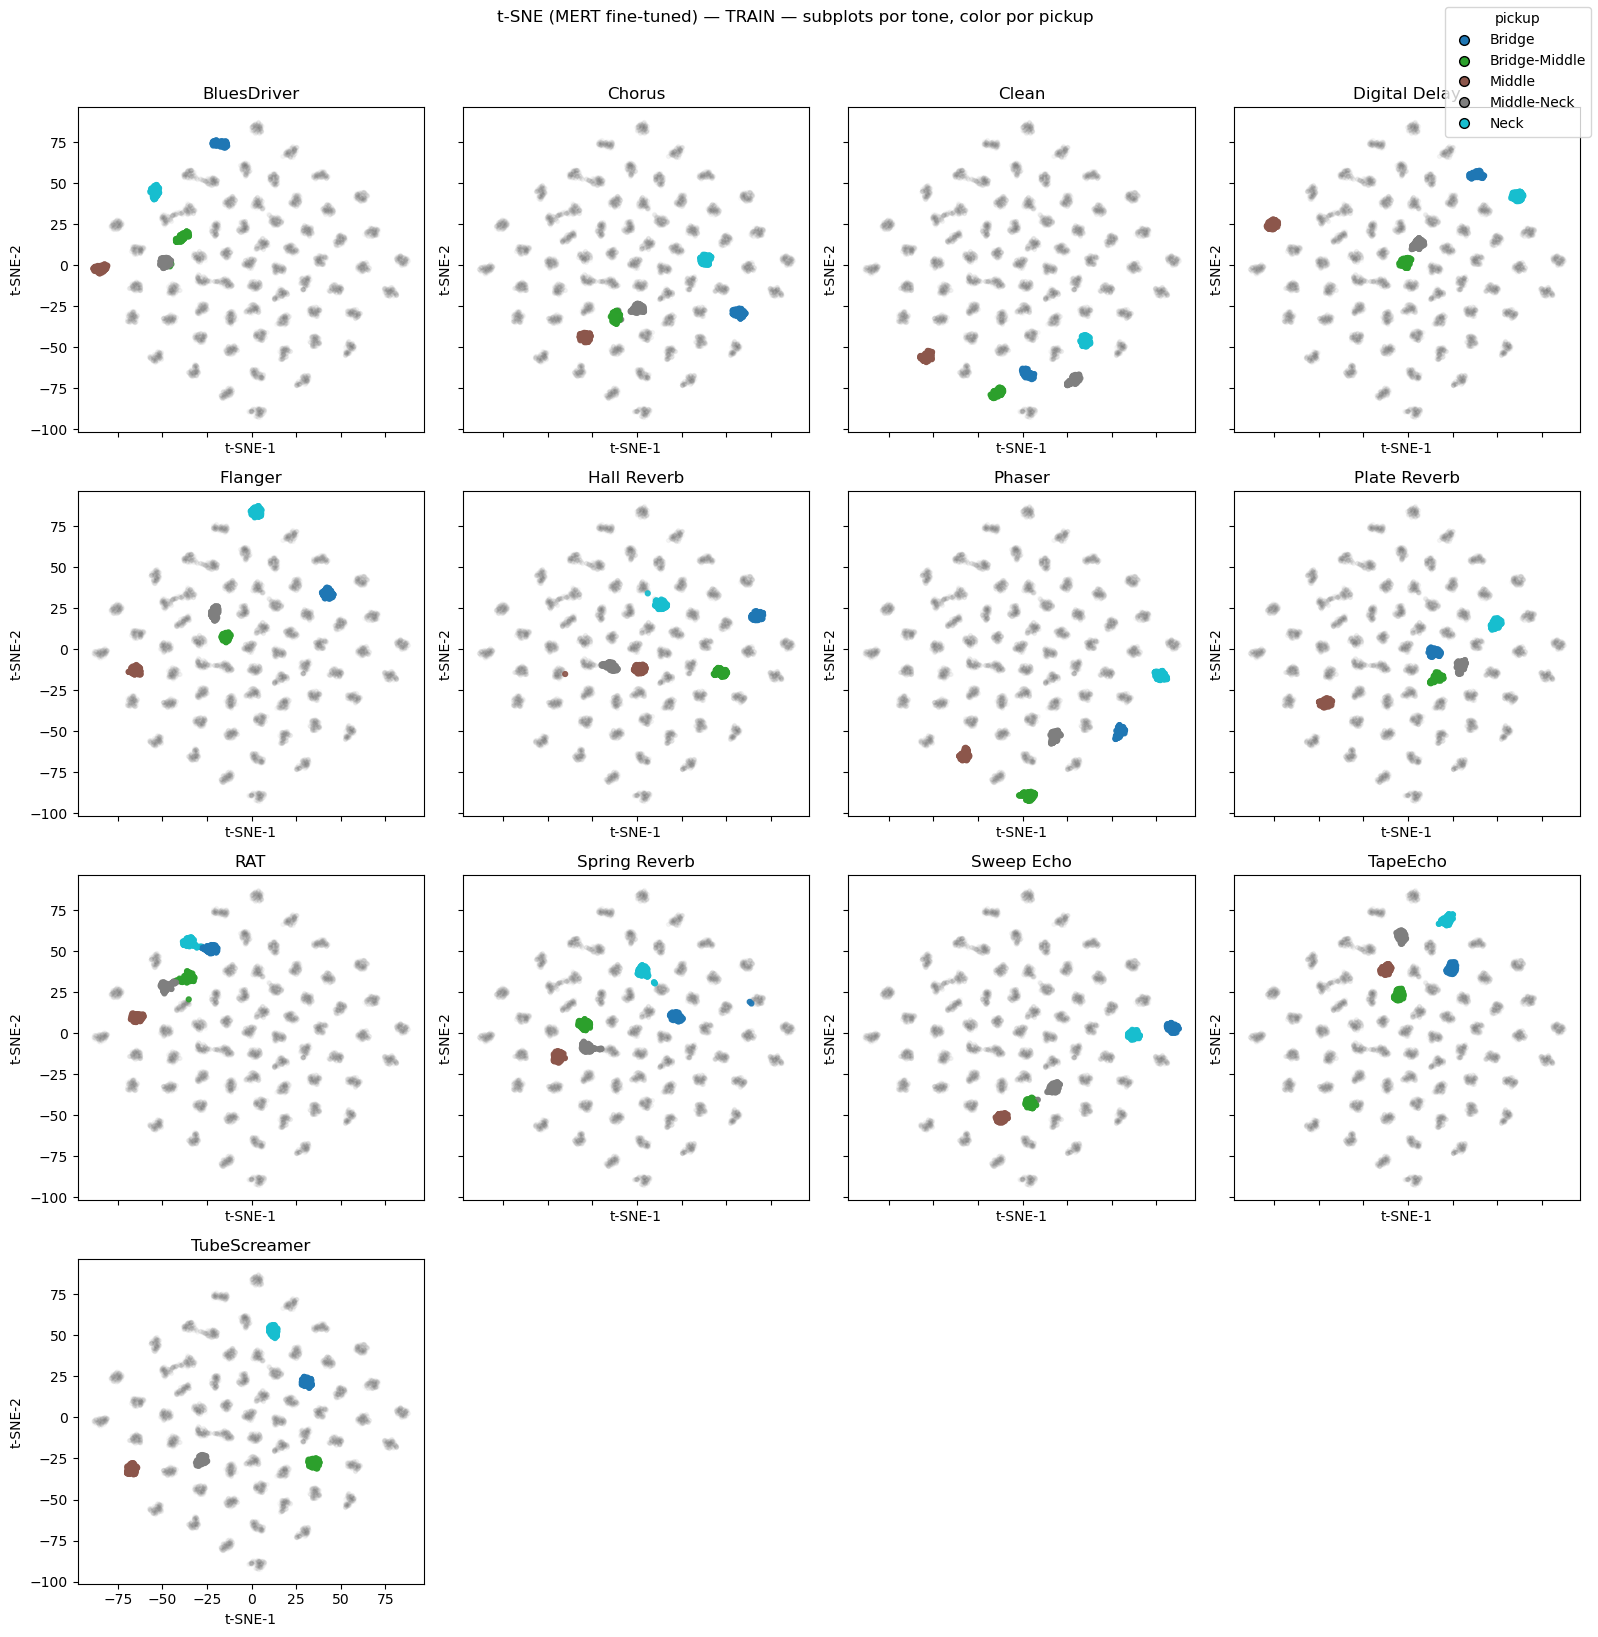

t-SNE perplexity (VAL): 30
Saved: outputs_02_mert_finetune_egfxset/figures_mert_ft/mert_ft_tsne_global_val_tone_pickup.png


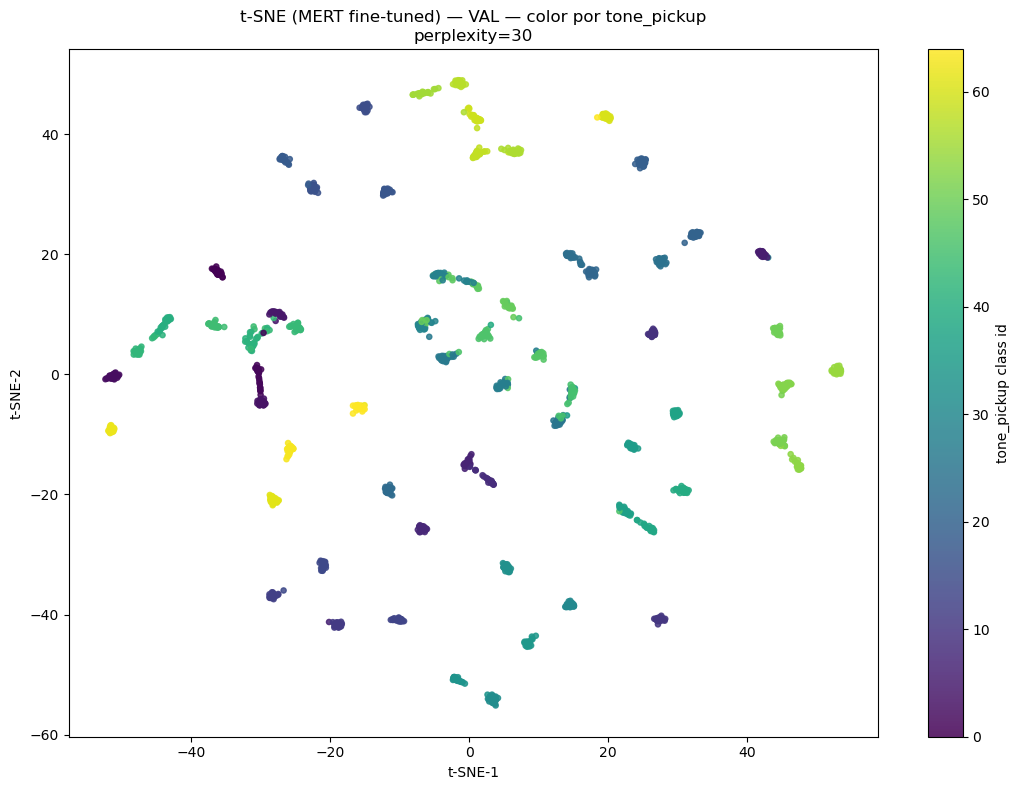

Saved: outputs_02_mert_finetune_egfxset/figures_mert_ft/mert_ft_tsne_subplots_val_tone_color_pickup.png


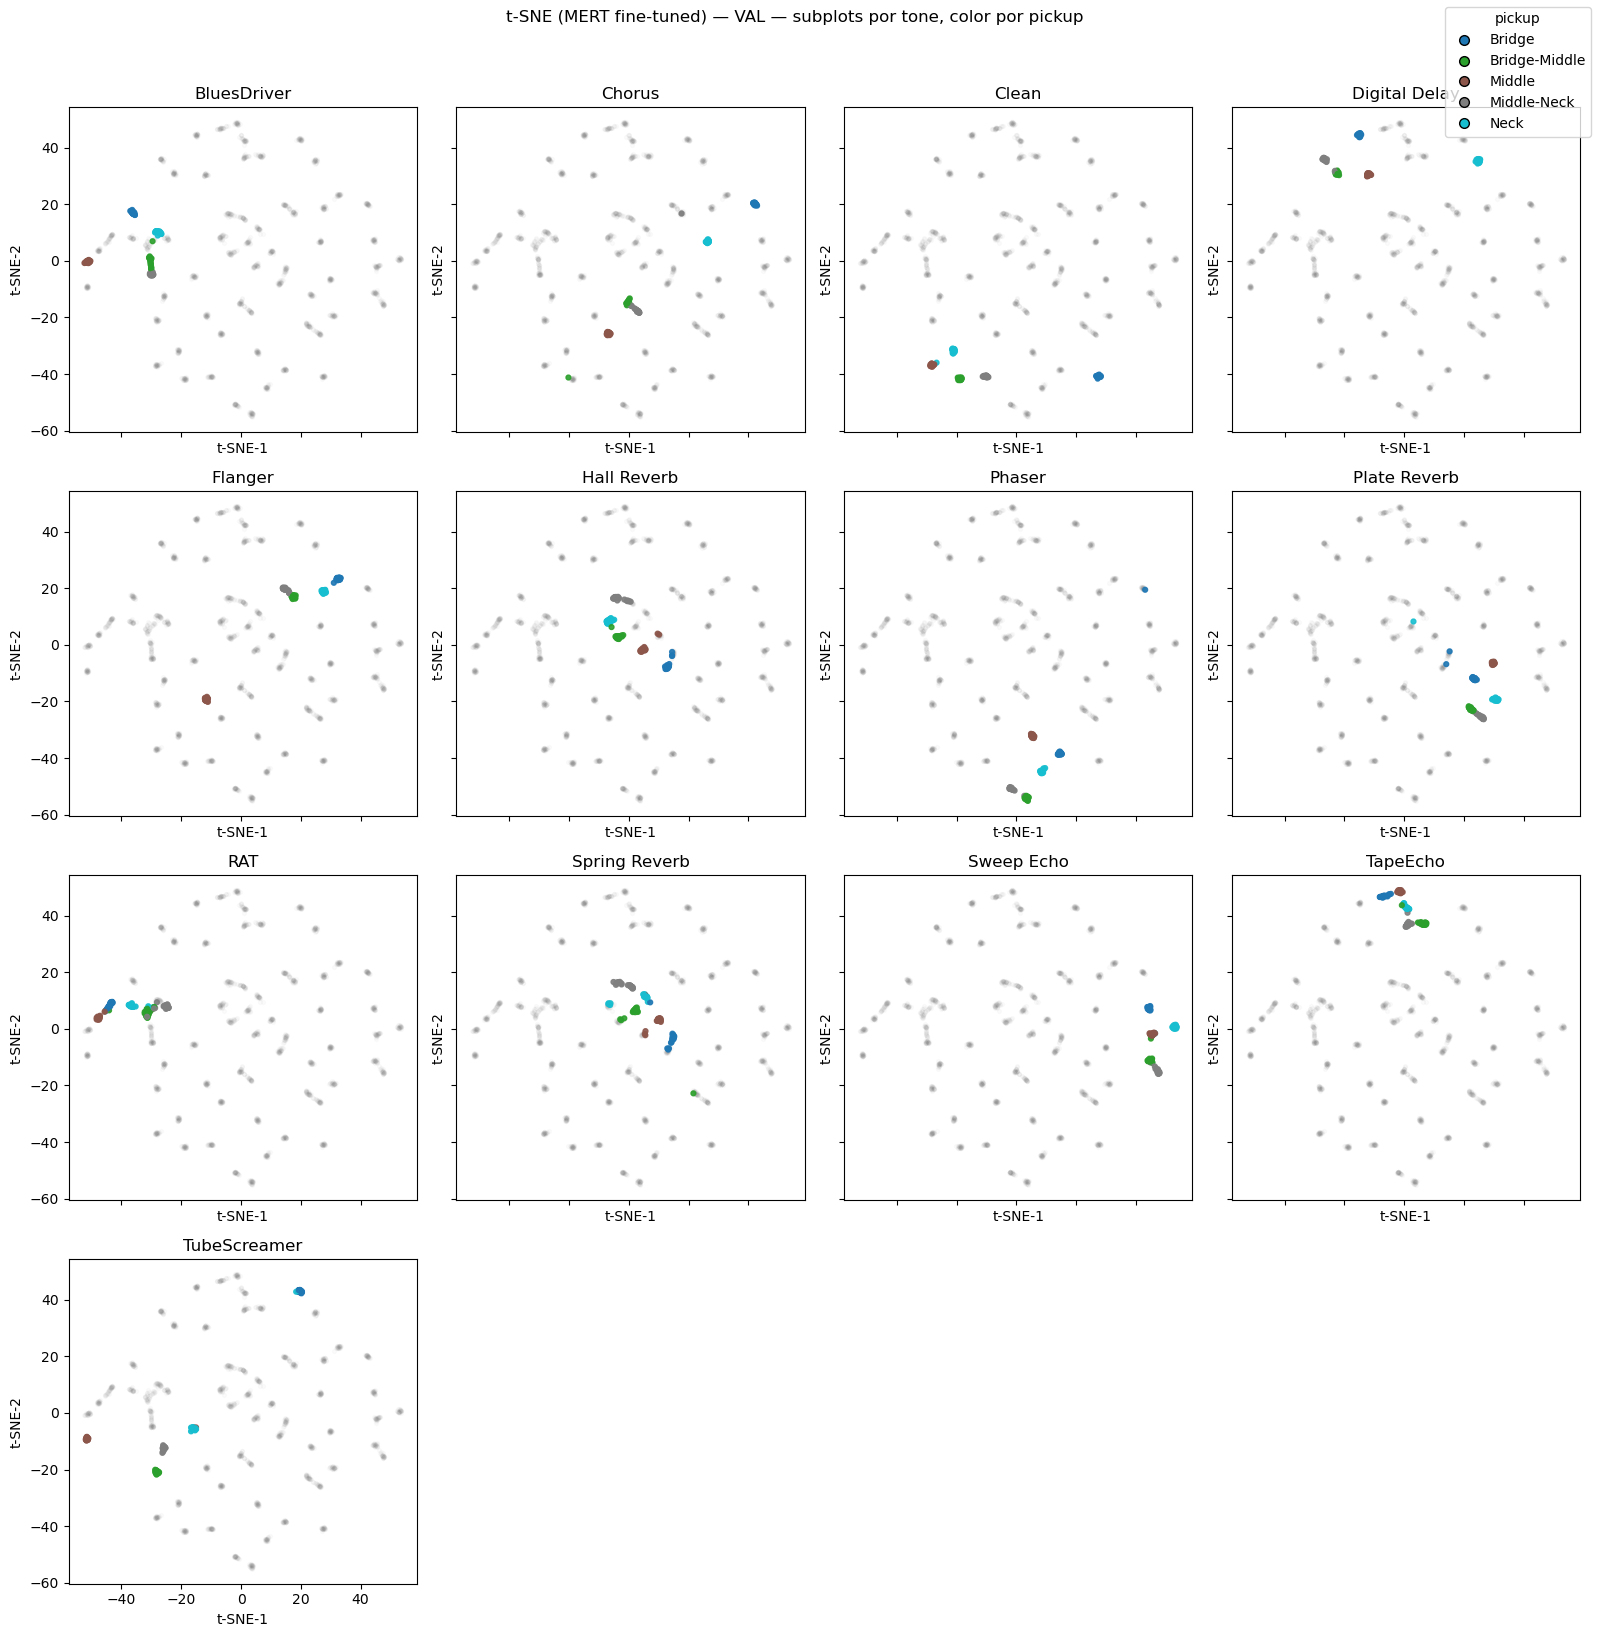

Saved t-SNE arrays in outputs_02_mert_finetune_egfxset


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


FIG_DIR = OUT_DIR_02 / "figures_mert_ft"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(fig, name, dpi=300):
    name = name if name.lower().endswith(".png") else f"{name}.png"
    out = FIG_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight")
    print("Saved:", out)

def tsne_fit_like_original(X, random_state=42):

    X = X.astype(np.float32)
    X = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-9)


    pca_dim = min(50, X.shape[1])
    X_pca = PCA(n_components=pca_dim, random_state=random_state).fit_transform(X)


    N = X_pca.shape[0]
    perplexity = max(5, min(30, (N - 1) // 3))

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        random_state=random_state,
    )
    Z = tsne.fit_transform(X_pca)
    return Z, perplexity

def plot_tsne_global_color_tone_pickup(Z, labels_tone_pickup, title, fig_name):
    uniq = sorted(set(labels_tone_pickup.tolist()))
    lab2i = {u:i for i,u in enumerate(uniq)}
    c = np.array([lab2i[x] for x in labels_tone_pickup], dtype=int)

    plt.figure(figsize=(11, 8))
    plt.scatter(Z[:, 0], Z[:, 1], c=c, s=14, alpha=0.85)
    plt.title(title)
    plt.xlabel("t-SNE-1")
    plt.ylabel("t-SNE-2")
    cb = plt.colorbar()
    cb.set_label("tone_pickup class id")
    plt.tight_layout()
    savefig(plt.gcf(), fig_name)
    plt.show()
    plt.close(plt.gcf())

def plot_tsne_subplots_by_tone_color_pickup(Z, df_subset, title_prefix, fig_name):

    if not {"tone","pickup"}.issubset(set(df_subset.columns)):
        print("SKIP subplots: faltan columnas 'tone' y/o 'pickup' en df_subset.")
        return

    tones = sorted(df_subset["tone"].astype(str).unique())
    pickups = sorted(df_subset["pickup"].astype(str).unique())

    p2i = {p:i for i,p in enumerate(pickups)}
    pickup_ids = df_subset["pickup"].astype(str).map(p2i).to_numpy()

    cmap = plt.get_cmap("tab10", len(pickups))

    n = len(tones)
    ncols = 4
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(16, 4*nrows),
        sharex=True,
        sharey=True
    )
    axes = np.array(axes).reshape(-1)

    tone_arr = df_subset["tone"].astype(str).to_numpy()

    for ax, t in zip(axes, tones):
        m = (tone_arr == t)


        ax.scatter(
            Z[~m, 0], Z[~m, 1],
            s=8, alpha=0.03, color="grey"
        )


        ax.scatter(
            Z[m, 0], Z[m, 1],
            c=pickup_ids[m],
            cmap=cmap,
            s=12,
            alpha=0.9,
            vmin=0,
            vmax=len(pickups)-1
        )

        ax.set_title(t)
        ax.set_xlabel("t-SNE-1")
        ax.set_ylabel("t-SNE-2")


    for k in range(len(tones), len(axes)):
        axes[k].axis("off")


    handles = [
        plt.Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            markersize=7,
            markerfacecolor=cmap(i),
            markeredgecolor='black',
            label=p
        )
        for p, i in p2i.items()
    ]

    fig.legend(
        handles=handles,
        title="pickup",
        loc="upper right"
    )

    fig.suptitle(title_prefix, y=1.02)
    plt.tight_layout()
    savefig(fig, fig_name)
    plt.show()
    plt.close(fig)


labels_train = train_df[LABEL_COL].astype(str).to_numpy()
Z_train, perp_train = tsne_fit_like_original(X_train, random_state=SEED)
print("t-SNE perplexity (TRAIN):", perp_train)

plot_tsne_global_color_tone_pickup(
    Z_train, labels_train,
    title=f"t-SNE (MERT fine-tuned) — TRAIN — color por tone_pickup\nperplexity={perp_train}",
    fig_name="mert_ft_tsne_global_train_tone_pickup"
)
plot_tsne_subplots_by_tone_color_pickup(
    Z_train, train_df,
    title_prefix=f"t-SNE (MERT fine-tuned) — TRAIN — subplots por tone, color por pickup",
    fig_name="mert_ft_tsne_subplots_train_tone_color_pickup"
)


labels_val = val_df[LABEL_COL].astype(str).to_numpy()
Z_val, perp_val = tsne_fit_like_original(X_val, random_state=SEED)
print("t-SNE perplexity (VAL):", perp_val)

plot_tsne_global_color_tone_pickup(
    Z_val, labels_val,
    title=f"t-SNE (MERT fine-tuned) — VAL — color por tone_pickup\nperplexity={perp_val}",
    fig_name="mert_ft_tsne_global_val_tone_pickup"
)
plot_tsne_subplots_by_tone_color_pickup(
    Z_val, val_df,
    title_prefix=f"t-SNE (MERT fine-tuned) — VAL — subplots por tone, color por pickup",
    fig_name="mert_ft_tsne_subplots_val_tone_color_pickup"
)


np.save(OUT_DIR_02 / "tsne_train_mert_ft.npy", Z_train)
np.save(OUT_DIR_02 / "tsne_val_mert_ft.npy", Z_val)
print("Saved t-SNE arrays in", OUT_DIR_02)

### 25. Resumen adicional de métricas LOO por split


In [34]:
import numpy as np
import pandas as pd

LABEL_COL = "tone_pickup"

def l2_normalize(X, eps=1e-9):
    X = X.astype(np.float32)
    n = np.linalg.norm(X, axis=1, keepdims=True)
    n = np.maximum(n, eps)
    return X / n

def topk_metrics_loo(X, labels, k_list=(1,5)):
    """
    Leave-one-out retrieval sobre el mismo conjunto:
    - L2 normalize
    - cosine sim matrix
    - diagonal = -inf (no puede recuperarse a sí mismo)
    - Top-k por similitud
    """
    Xn = l2_normalize(X)
    S = Xn @ Xn.T
    np.fill_diagonal(S, -np.inf)

    maxK = max(k_list)


    top_idx = np.argpartition(-S, kth=maxK-1, axis=1)[:, :maxK]
    row = np.arange(S.shape[0])[:, None]
    top_idx = top_idx[row, np.argsort(-S[row, top_idx], axis=1)]


    retrieved = labels[top_idx]

    metrics = {}
    for k in k_list:
        hit = (retrieved[:, :k] == labels[:, None]).any(axis=1)
        metrics[f"top_{k}"] = float(hit.mean())

    pred_top1 = retrieved[:, 0].copy()
    return metrics, pred_top1


train_labels = train_df[LABEL_COL].astype(str).to_numpy()
m_tr, pred_train_top1 = topk_metrics_loo(X_train, train_labels, k_list=(1,5))


val_labels = val_df[LABEL_COL].astype(str).to_numpy()
m_va, pred_val_top1 = topk_metrics_loo(X_val, val_labels, k_list=(1,5))


classes_all = sorted(pd.concat([train_df[LABEL_COL], val_df[LABEL_COL]]).astype(str).unique().tolist())
C = len(classes_all)
chance = 1.0 / C

results = pd.DataFrame([
    ["MERT fine-tuned", "TRAIN (LOO)", X_train.shape[1], m_tr["top_1"], m_tr["top_5"]],
    ["MERT fine-tuned", "VAL (LOO)",   X_val.shape[1],   m_va["top_1"], m_va["top_5"]],
], columns=["Modelo","Configuración","Dimensión","Top-1","Top-5"])

results["Chance (1/C)"] = chance
results["Top-1 vs chance"] = results["Top-1"] / chance

display(results)


pred_train = pred_train_top1
pred_val   = pred_val_top1

,Modelo,Configuración,Dimensión,Top-1,Top-5,Chance (1/C),Top-1 vs chance
0,MERT fine-tuned,TRAIN (LOO),256,0.997625,0.998882,0.015385,64.845606
1,MERT fine-tuned,VAL (LOO),256,0.954190,0.980447,0.015385,62.022346
